# BANK_NOTE_AUTHENTICATION using TENSORFLOW
#### AIM:
To detect forged notes based on the data(from WTI) from a set of forged and genuine bank_note_specimens.

## DATA set

The data set was taken from the <a href='https://archive.ics.uci.edu/ml/datasets/banknote+authentication'>UCI Repository</a>
it contain 1,372 banknotes(observations) and 4 attributes.

### Information about the dataset
1.Image.Var: Variance of Wavelet Transformed image (WTI) (continuous)
2.Image.Skew: Skewness of WTI (continuous)
3.Image.Curt: Curtosis of WTI (continuous)
4.Entropy: Entropy of image (continuous)
5.Class: Whether or not the banknote was authentic (integer)

## IMPORTS
load necessary Python libraries and load the input data. Note that the last column from this dataset, 'class', will be my target label (whether an note is fake(0), or genuine(1)). All other columns are features about each image in the input database

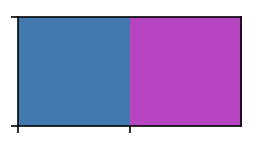

In [134]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Set palette
color = sns.diverging_palette(245,663,sep=100, n=2)
sns.palplot(color)

## Reading the data using pandas
import the input CSV file and store it in a Pandas dataframe called data. I can get the dimensions of the dataset using .shape.


In [135]:
# Import dataset
data = pd.read_csv('input.csv')

In [136]:
data.shape

(1372, 5)

### We can also use the .head(), .info(), and .describe() methods to learn more about our data.

In [137]:
data.head()

,Image.Var,Image.Skew,Image.Curt,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
Image.Var     1372 non-null float64
Image.Skew    1372 non-null float64
Image.Curt    1372 non-null float64
Entropy       1372 non-null float64
Class         1372 non-null int64
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [139]:
data.describe()

,Image.Var,Image.Skew,Image.Curt,Entropy,Class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


#### finding if there are any missing values in the dataset. I found to be none and this can be easily explored

In [140]:
#missing value counts in each of these columns
miss = data.isnull().sum()/len(data)
miss = miss[miss > 0]
miss.sort_values(inplace=True)
miss

Series([], dtype: float64)

In [141]:
get_ipython().magic('matplotlib inline')

### EXPLORING DATA ANALYSIS
Now I have imported our data, i am plotting some graphs to see how my data is distributed. First, I can use Seaborn’s Countplot to see how many fake and real banknotes there are in the dataset.
- It seems like i have a lot more fake banknotes in our dataset.

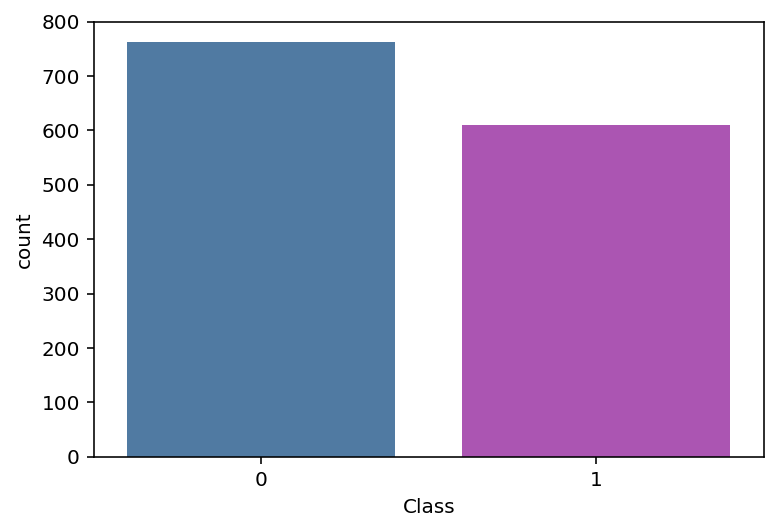

In [142]:
sns.countplot(x="Class", data=data, palette=color)

### Next, I tried to find relationships between the other attributes in my dataset (in relation to our target class). I can use a FacetGrid from Seaborn, with sharex and sharey set to false. This way we can easily see how the relationships differ between real and fake banknotes.

C:\Users\csedept\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\csedept\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\csedept\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\csedept\Anaconda3\envs\tensorflow\lib\site-packages\matplot

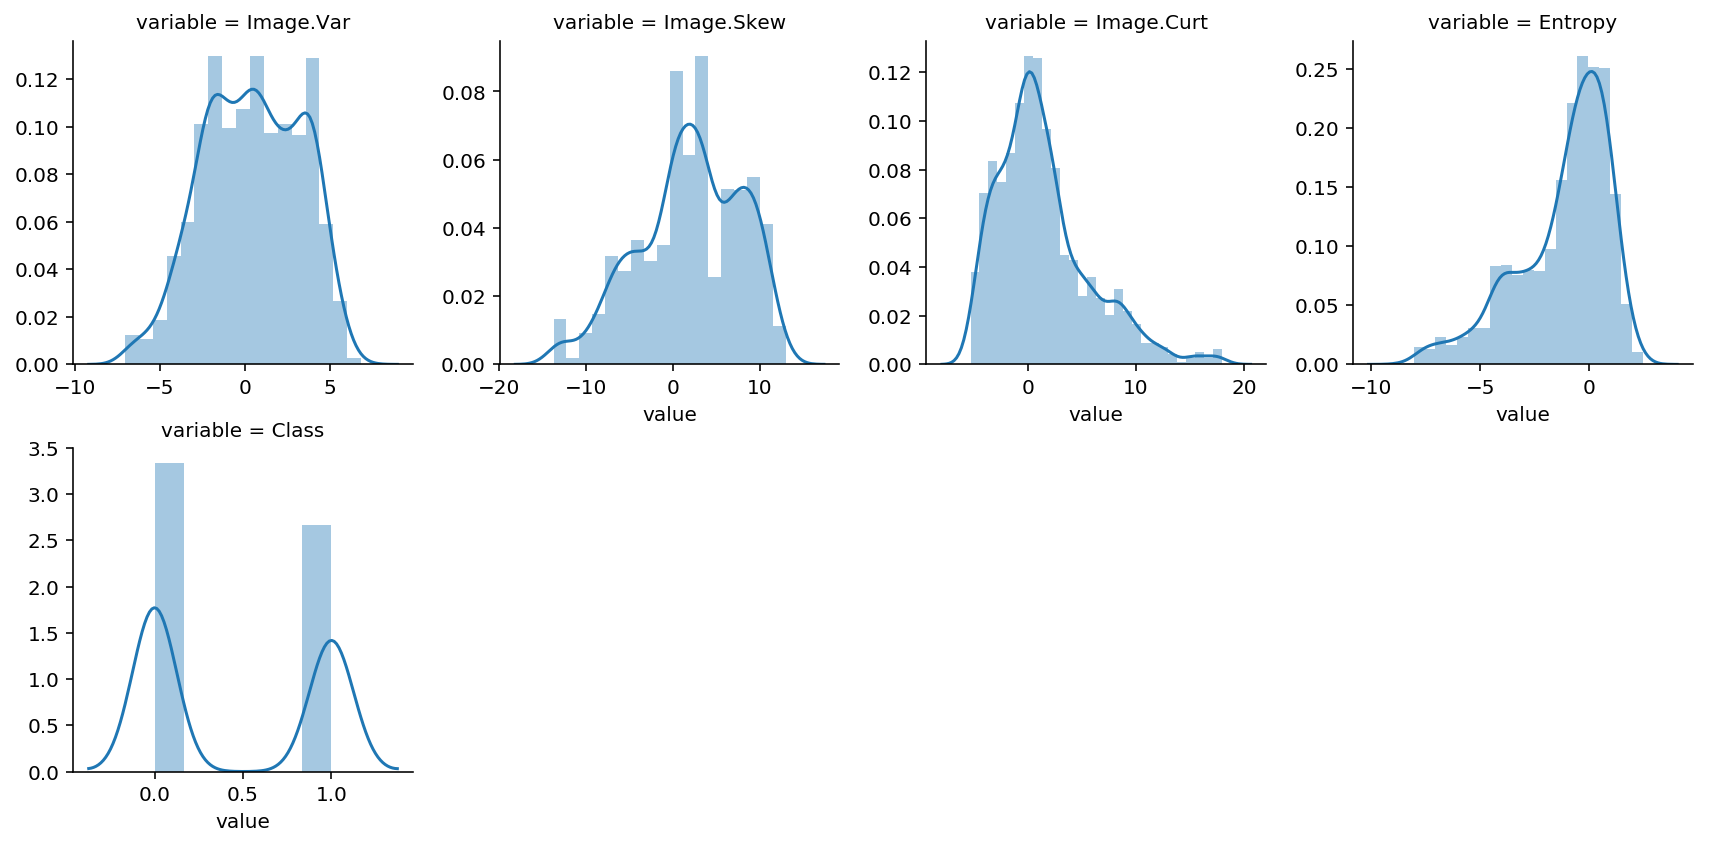

In [143]:
#create numeric plots
num = [f for f in data.columns if data.dtypes[f] != 'object']
nd = pd.melt(data, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

# Standardising the data
### I think When using neural network and deep learning-based systems, it’s usually a good idea to standardise my data. I don’t need to standardise the Class attribute since it is a target, so let’s create a separate dataframe to store the other features.

### Next, I fit a StandardScaler object from the Scikit-learn library on the independent variables and store the transformed data in a new dataframe called scld_features.


In [144]:
# Create a new dataframe with 'Class' removed
no_class = data.drop('Class', axis=1)

# Fit scaler
sc = StandardScaler()
sc.fit(no_class)

# Store scaled features as a separate dataframe
scld_features = pd.DataFrame(data=sc.transform(no_class), columns=no_class.columns)
scld_features.head()

,Image.Var,Image.Skew,Image.Curt,Entropy
0,1.121806,1.149455,-0.975970,0.354561
1,1.447066,1.064453,-0.895036,-0.128767
2,1.207810,-0.777352,0.122218,0.618073
3,1.063742,1.295478,-1.255397,-1.144029
4,-0.036772,-1.087038,0.736730,0.096587


# Train_test_split

### i seperated the forged and authentic classes to do this first i created the 'authentic' feature then initialed the opposite value (0 for 1 and 1 for 0) for 'forged' 

### since we have 2 classes (authentic and forged) for our dependent variable, we can separate these into two different columns.also the forged notes are more than the authentic(genuine) notes, I think it would be better to divide the class into aunthentic and create a feature forged.

In [145]:
# Rename 'Class' attribute to 'Authentic'
data = data.rename(columns={'Class': 'Authentic'})

# Create 'Forged' attribute
data.loc[data['Authentic'] == 0, 'Forged'] = 1
data.loc[data['Authentic'] == 1, 'Forged'] = 0

data.head()

,Image.Var,Image.Skew,Image.Curt,Entropy,Authentic,Forged
0,3.62160,8.6661,-2.8073,-0.44699,0,1.0
1,4.54590,8.1674,-2.4586,-1.46210,0,1.0
2,3.86600,-2.6383,1.9242,0.10645,0,1.0
3,3.45660,9.5228,-4.0112,-3.59440,0,1.0
4,0.32924,-4.4552,4.5718,-0.98880,0,1.0


#### I am vcreating Variable **X **(FEATURES)** and ***y ***(labels) i.e pandas dataframe and series and the convert them into numpy arrays.

In [146]:
X = scld_features
y = data[['Authentic', 'Forged']]

X = X.values
y = y.values


### I have my independent and dependent variables, I am using Scikit-learn’s train_test_split to split our data into a training and a test set. We will use 25% of the original dataset for testing.Split the data into testing and training sets using train_test_split where test_size=0.25 comprises of 25% of total data.
### I also have printed out the shapes of X_train, X_test, y_train, and y_test. It will help when defining parameters for our neural network.

In [147]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=52)

# Shapes

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (1029, 4)
X_test shape: (343, 4)
y_train shape: (1029, 2)
y_test shape: (343, 2)


# Parameters 
#### rate of learning:
The learning rate of the model is a value between 0 and 1. It can be thought of as a measure of how quickly our model abandons old beliefs for new ones. A high rate means that the network changes its mind more quickly, and a lower rate means that it is reluctant to change. Here we will choose a learning rate of 0.01.
#### number of training epochs:
One epoch means one pass of the training set. We want our model to go through the training set more than just once, to improve accuracy. However it is important to note that a very high number of epochs results in the risk of overfitting. Overfitting reduces the performance of our neural net on unseen data. Let’s set the number of training epochs to 100.
#### size of batch:
Finally, we can set the batch size to 100. We will be using batch learning, and a batch size of 100 means that we will update our weights using back-propagation after every 100 predictions.

Before setting up my neural network, it is important to define the parameters for my model. I think I have to adjust these a bit later on, depending on how my model performs.First I have set the learning rate, the number of training epochs, and the batch size.

- It is also important to set the parameters for my network, and not just for the training. This includes the number of nodes for each layer in our model (namely the input layer, the hidden layer(s), and the output layer).

## Tensorflow graph input
I have defined my parameters, Now let me define the inputs I feed into my TensorFlow graph. x and y can be defined as matrix (or tensor) placeholders.

In [148]:
# Parameters
rate_of_learning = 0.01
num_training_epochs = 120
size_of_batch = 100

# Neural network parameters
num_hidden_1 = 4 # # nodes in first hidden layer
num_hidden_2 = 4 # # nodes in second hidden layer
num_input = 4 # input shape
num_classes = 2 # total classes (authentic / forged)
num_samples = X_train.shape[0]

# Graph input
x = tf.placeholder(tf.float32, [None, num_input])
y = tf.placeholder(tf.float32, [None, num_classes])

## Multilayered perceptron
I have finally ready to set up my neural network! I will create a function that accepts the input x, a dictionary of weights, and a dictionary of biases. I am using the ReLU activation function for each layer.
#### COMPUTATION
###### g(x)=(X*W)+b
#### RELU ACTIVATION FUNCTION
###### f(g(x))=max(0,g(x))


In [149]:
def mp(x, weights, biases):
    
    '''
    x : Placeholder for data input
    weights: Dictionary of weights
    biases: Dictionary of biases
    
    '''
    
    # First hidden layer with ReLU
    # (X * W) + B
    lr_1 = tf.add(tf.matmul(x, wgts['h_1']), bias['b_1'])
    # RELU: ((X * W) + B) -> f(x) = max(0,x)
    lr_1 = tf.nn.relu(lr_1)
    
    # Second hidden layer with ReLU
    lr_2 = tf.add(tf.matmul(lr_1, wgts['h_2']), bias['b_2'])
    lr_2 = tf.nn.relu(lr_2)
    
    # Output layer with linear activation
    outer_layer = tf.matmul(lr_2, wgts['out'] + bias['out'])
    return outer_layer

# Weights and Biases
Next, I need to define the weights and bias for each layer in my network. I will create dictionaries of weights and biases using the parameters we’ve already defined.
- My network had 3 layers (2 hidden layers and an output layer, excluding the input layer).


In [150]:
wgts = {
    'h_1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'h_2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_hidden_2, num_classes]))
}

In [151]:
bias = {
    'b_1': tf.Variable(tf.random_normal([num_hidden_1])),
    'b_2': tf.Variable(tf.random_normal([num_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

### I can set the predictions to be a tensor called preds, and it will contain the output from our neural network. printing it will have a clean idead about the neural network.

In [152]:
# Construct model
preds = mp(x, wgts, bias)
print(preds)

Tensor("MatMul_14:0", shape=(?, 2), dtype=float32)


# Cost and Optimization
I have used a softmax cross-entropy function for calculating the loss, and the adam optimiser to minimise cost.

In [153]:
# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=preds))
optimizer = tf.train.AdamOptimizer(learning_rate=rate_of_learning).minimize(loss)
print(loss)
print('OPTIMIZER:',optimizer)

Tensor("Mean_8:0", shape=(), dtype=float32)
OPTIMIZER: name: "Adam_4"
op: "NoOp"
input: "^Adam_4/update_Variable_24/ApplyAdam"
input: "^Adam_4/update_Variable_25/ApplyAdam"
input: "^Adam_4/update_Variable_26/ApplyAdam"
input: "^Adam_4/update_Variable_27/ApplyAdam"
input: "^Adam_4/update_Variable_28/ApplyAdam"
input: "^Adam_4/update_Variable_29/ApplyAdam"
input: "^Adam_4/Assign"
input: "^Adam_4/Assign_1"



# initialising the variables using tensorflow

In [154]:
# Initialize variables
init = tf.global_variables_initializer()

# training the model
In TensorFlow, graphs aren’t executed unless a Session is created and run. The session allocates resources for the graph, and holds the actual values of intermediate results and variables.

I had have two loops:

The outer loop runs the epochs, and
The inner loop runs the batches for each epoch.


After each epoch, my can print out the cost and append it to a list of costs.I can plot a line graph after training to visualise how my cost has been minimized


In [155]:
# Launch the session
session = tf.InteractiveSession()

# Intialize all the variables
session.run(init)

costs = []

for epoch in range(num_training_epochs):

    avg_cost = 0.0

    # Number of batches
    total_batch = int(num_samples/size_of_batch)

    # Loop over all batches
    for batch in range(total_batch):

        # Grab the next batch of training data and labels
        batch_x = X_train[batch*size_of_batch : (1+batch)*size_of_batch]
        batch_y = y_train[batch*size_of_batch : (1+batch)*size_of_batch]

        # Feed dictionary for optimization / Get loss value
        _, c = session.run([optimizer, loss], feed_dict={x: batch_x, y: batch_y})

        # Compute average loss
        avg_cost += c / total_batch
    
    print("Epoch: {} cost={:.4f}".format(epoch+1,avg_cost))
    costs.append(avg_cost)
    
print("Model has completed {} epochs of training.".format(num_training_epochs))

Epoch: 1 cost=4.7339
Epoch: 2 cost=2.8351
Epoch: 3 cost=1.7067
Epoch: 4 cost=1.0781
Epoch: 5 cost=0.7356
Epoch: 6 cost=0.5536
Epoch: 7 cost=0.4701
Epoch: 8 cost=0.3902
Epoch: 9 cost=0.2129
Epoch: 10 cost=0.0979
Epoch: 11 cost=0.0615
Epoch: 12 cost=0.0500
Epoch: 13 cost=0.0422
Epoch: 14 cost=0.0371
Epoch: 15 cost=0.0337
Epoch: 16 cost=0.0312
Epoch: 17 cost=0.0292
Epoch: 18 cost=0.0275
Epoch: 19 cost=0.0248
Epoch: 20 cost=0.0222
Epoch: 21 cost=0.0199
Epoch: 22 cost=0.0180
Epoch: 23 cost=0.0165
Epoch: 24 cost=0.0151
Epoch: 25 cost=0.0138
Epoch: 26 cost=0.0127
Epoch: 27 cost=0.0118
Epoch: 28 cost=0.0109
Epoch: 29 cost=0.0101
Epoch: 30 cost=0.0092
Epoch: 31 cost=0.0085
Epoch: 32 cost=0.0078
Epoch: 33 cost=0.0072
Epoch: 34 cost=0.0068
Epoch: 35 cost=0.0063
Epoch: 36 cost=0.0059
Epoch: 37 cost=0.0056
Epoch: 38 cost=0.0053
Epoch: 39 cost=0.0050
Epoch: 40 cost=0.0048
Epoch: 41 cost=0.0045
Epoch: 42 cost=0.0043
Epoch: 43 cost=0.0041
Epoch: 44 cost=0.0039
Epoch: 45 cost=0.0037
Epoch: 46 cost=0.00

#### Below is a graph of the cost over time, created using the list of costs.

Text(0,0.5,'Cost')

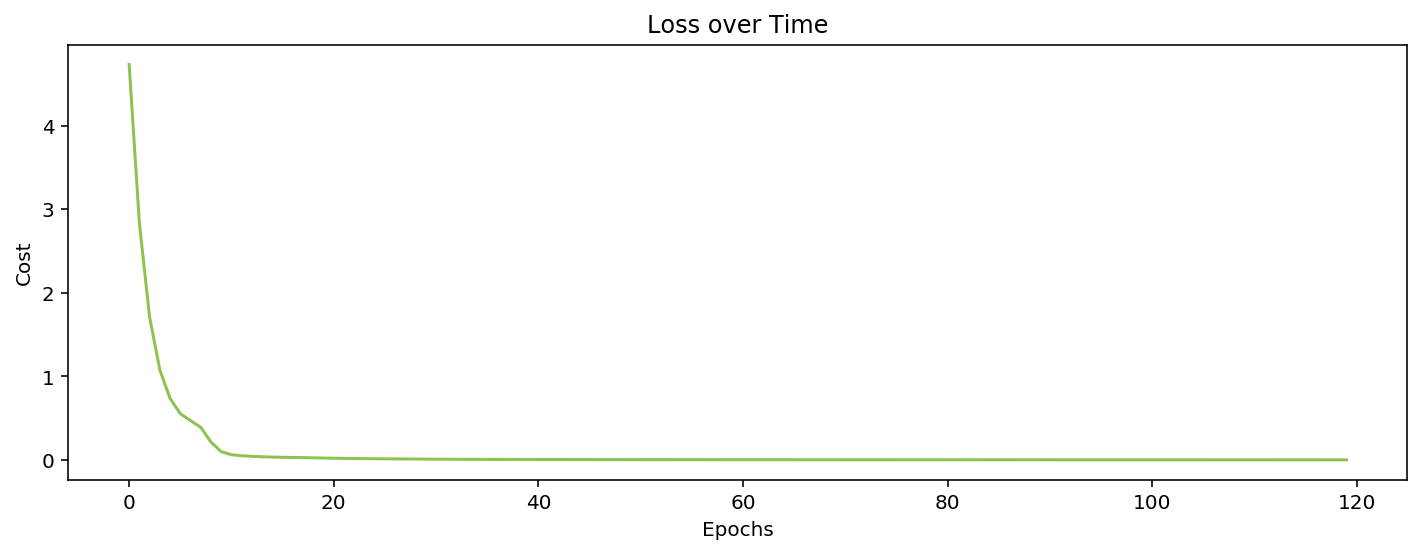

In [156]:
# Visualize loss over time
costs_df = pd.Series(data=costs)
costs_df.plot(figsize=(12, 4), title='Loss over Time', color='#8ec24f')
plt.xlabel('Epochs')
plt.ylabel('Cost')

## evaluating the model
testing the the trained model for the given data.

My model has now been trained! 

To see how well it performs on the test set, let me count the number of correct predictions on the test set. 

I can then define the accuracy as the mean percentage of correct predictions.

In [157]:
# Test model
crct_predictions = tf.cast(tf.equal(tf.argmax(preds, 1), tf.argmax(y, 1)), tf.float32)
print(crct_predictions[0])

Tensor("strided_slice_4:0", shape=(), dtype=float32)


## calculating the accuracy score for the tested data
To get the accuracy, I have to use the .eval() method and pass in a dictionary for the placeholders x and y.

In [158]:
# Accuracy
accuracy_score = tf.reduce_mean(crct_predictions)

# Evaluate accuracy and print
print("Accuracy_score:", accuracy_score.eval(feed_dict={x: X_test, y: y_test}))

Accuracy_score: 1.0


Hurrah!, it looks like my model has achieved a 100% accuracy with the test set! Maybe the dataset was a little easy for my model to classify. Although we performed well, it’s important to take a step back and think about what I have caused an accuracy this high. 
#### problems i have faced:
I Tried to change my number of epochs batch size and learning rate to 150,100,0.02 but this made me fall into a accuracy score lesser than 99%.
this gave me a poor performance when i have changed them to a lower values like 30,56,0.001 because this lead me to an underfitting 
 the correct solution that would be found is to set them appropriate 100,100,0.01 that gave me 100% accuracy

C:\Users\csedept\Anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\csedept\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\csedept\Anaconda3\envs\tensorflow\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\csedept\Anaconda3\envs\tensorflow\lib\site-packages\matplot

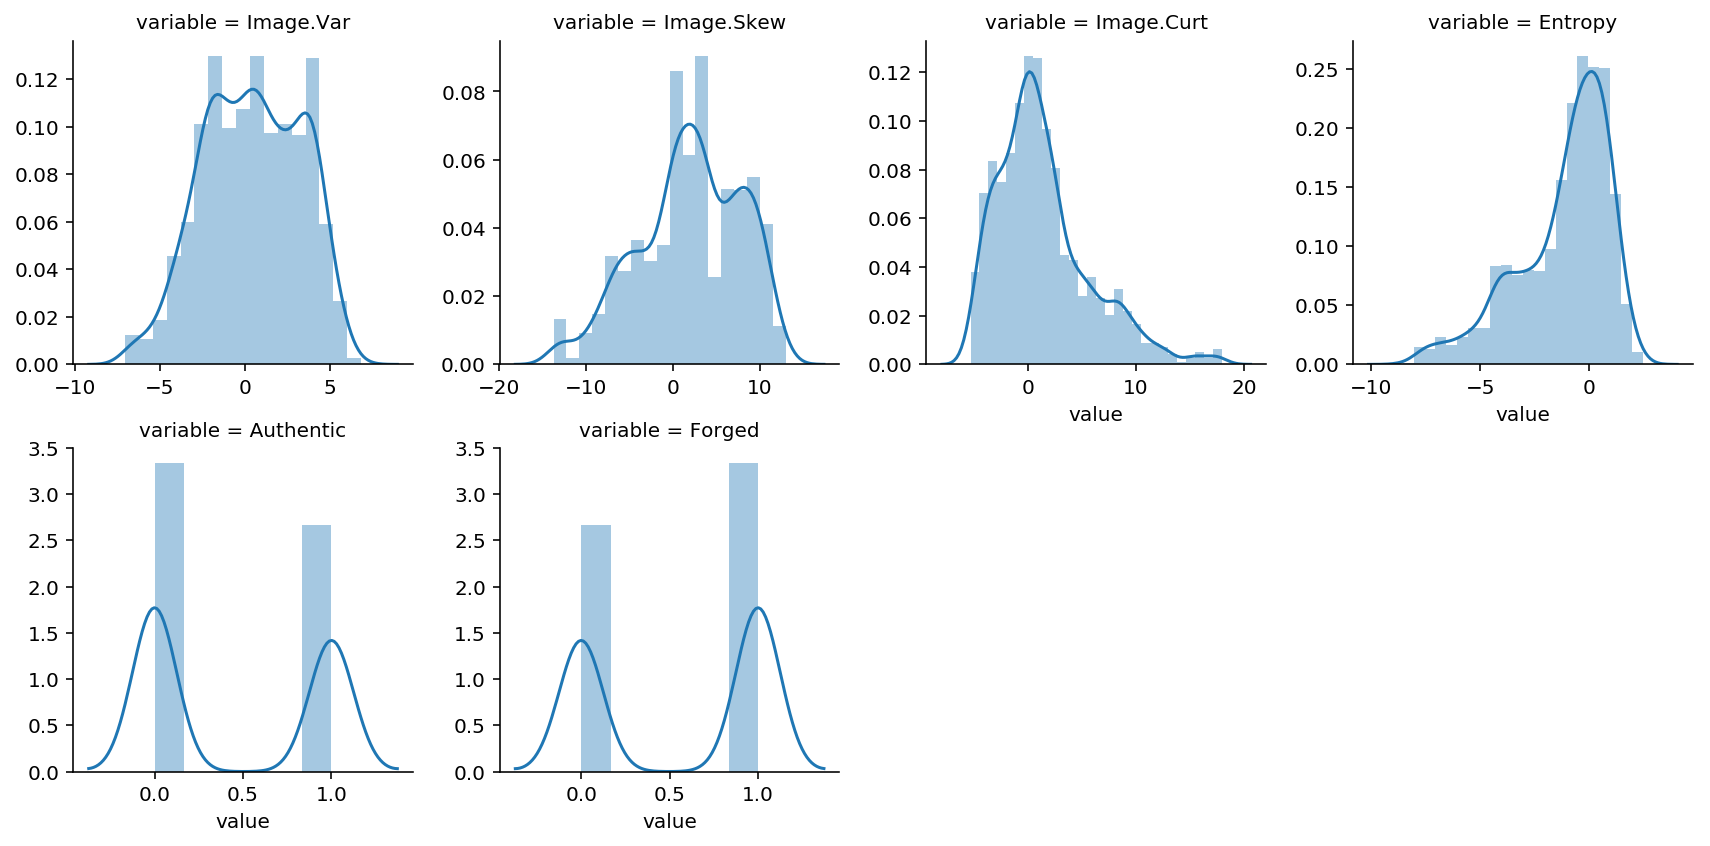

In [159]:
#create numeric plots
num = [f for f in data.columns if data.dtypes[f] != 'object']
nd = pd.melt(data, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

## comparing with the randomboost classifier
yes,we are accurate enough since 1 is the highest.
but,we have to check if any other classifier is good enough than our classifier so that we can know its performance.

Since my neural network was pretty much spot on with its predictions, it’s important that i have compared it with another model for a reality check.

I will use a random forest classifier. Let me train it on the same dataset, and store the predictions in a separate dataframe called preds_rfc.

In [160]:
# Build and train random forest classifier
rfc = RandomForestClassifier(n_estimators=100) 
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [161]:
# Get predictions from random forest classifier
preds_rfc = rfc.predict(X_test)
print(preds_rfc)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 

## THE  REPORT AFTER CLASSIFICATION

##### Next, I have evaluated my predictions using a classification report and a confusion matrix.

In [162]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,preds_rfc)

0.9941690962099126

### Confusion matrix

In [163]:
# Get only the 'Forged' column values from y_test and preds_rfc
k=confusion_matrix(y_test.argmax(axis=1),preds_rfc.argmax(axis=1))

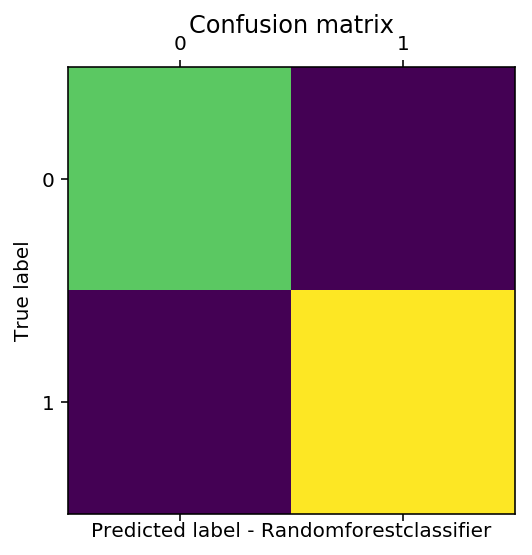

[[146   1]
 [  1 195]]


In [164]:
plt.matshow(k)
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label - Randomforestclassifier')
plt.show()
print(k)

In [165]:
print(classification_report(y_test,preds_rfc))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99       147
          1       0.99      0.99      0.99       196

avg / total       0.99      0.99      0.99       343



# Conclusion:
#### problems i have faced:
I Tried to change my number of epochs,batch size and learning rate to 150,100,0.02 but this made me fall into a accuracy score lesser than 99%.
this gave me a poor performance when i have changed them to a lower values like 30,56,0.001 because this lead me to an underfitting 
 the correct solution that would be found is to set them appropriate 120,10,0.01 that gave me 100% accuracy



and hence
randomBoost Classifier gave a score of 99% accuracy where as the neural network gave me 100%.hence I can conclude that my neural network is far better than randomboost classifier.so it’s safe to conclude that my dataset was probably just easy to classify.